In [2]:
#setup

# digit 8
from __future__ import absolute_import, division, print_function

# %tensorflow_version 1.x
from tqdm.notebook import tqdm
import numpy as np
import cv2 #pip install opencv-python
import scipy
import scipy.spatial
from scipy import ndimage
from skimage import metrics #pip install scikit-image
import tensorflow as tf
import time

print('tf.__version__: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
from keras import datasets, layers, models

#from google.colab import drive
#drive.mount('/content/drive')

#test GPU
# gpu = tf.config.list_physical_devices('GPU')
# print(gpu)
# tf.config.experimental.set_memory_growth(device=gpu[0], enable=True)

#force to run on cpu
tf.config.set_visible_devices([], 'GPU')

tf.__version__: 2.10.1


In [3]:
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames

In [4]:
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter

def invert_colors(image1, image2):
    return cv2.bitwise_not(image1), cv2.bitwise_not(image2)

def elastic_distortion(image1, image2, alpha_range, sigma):
    random_state = np.random.RandomState(None)
    alpha = image1.shape[1] * alpha_range
    sigma = image1.shape[1] * sigma

    shape = image1.shape[:2]
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    distorted_image1 = map_coordinates(image1, indices, order=1, mode='reflect').reshape(image1.shape)
    distorted_image2 = map_coordinates(image2, indices, order=1, mode='reflect').reshape(image2.shape)

    return distorted_image1, distorted_image2

def random_erasing(image1, image2, p=0.5, sl=0.02, sh=0.4, r1=0.3, r2=3.3):
    if np.random.rand() > p:
        return image1, image2

    img_h, img_w = image1.shape[:2]
    area = img_h * img_w

    target_area = np.random.uniform(sl, sh) * area
    aspect_ratio = np.random.uniform(r1, r2)

    h = int(round(np.sqrt(target_area * aspect_ratio)))
    w = int(round(np.sqrt(target_area / aspect_ratio)))

    if w < img_w and h < img_h:
        x1 = np.random.randint(0, img_h - h)
        y1 = np.random.randint(0, img_w - w)
        image1_patch = np.random.rand(h, w) * 255
        image2_patch = np.random.rand(h, w) * 255

        image1[x1:x1 + h, y1:y1 + w] = image1_patch
        image2[x1:x1 + h, y1:y1 + w] = image2_patch

    return image1, image2


def gamma_correction(image1, image2, gamma=1.0):
    gamma_inv = 1.0 / gamma
    table = np.array([((i / 255.0) ** gamma_inv) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image1, table), cv2.LUT(image2, table)

def brightness_adjustment(image1, image2, alpha=1.0, beta=0.0):
    return cv2.convertScaleAbs(image1, alpha=alpha, beta=beta), cv2.convertScaleAbs(image2, alpha=alpha, beta=beta)

def saturation_adjustment(image1, image2, alpha=1.0):
    hsv1 = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
    hsv1[..., 1] = hsv1[..., 1] * alpha
    image1 = cv2.cvtColor(hsv1, cv2.COLOR_HSV2BGR)

    hsv2 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
    hsv2[..., 1] = hsv2[..., 1] * alpha
    image2 = cv2.cvtColor(hsv2, cv2.COLOR_HSV2BGR)

    return image1, image2

def contrast_adjustment(image1, image2, alpha=1.0):
    image_gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image_gray1 = (image_gray1 - image_gray1.mean()) * alpha + image_gray1.mean()
    image1 = cv2.cvtColor(image_gray1, cv2.COLOR_GRAY2BGR)

    image_gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    image_gray2 = (image_gray2 - image_gray2.mean()) * alpha + image_gray2.mean()
    image2 = cv2.cvtColor(image_gray2, cv2.COLOR_GRAY2BGR)

    return image1, image2

def augment_image_pair(image1, image2):
    # Generate random choice from 1 to 5
    choice = np.random.randint(1, 5)

    new_image1 = image1.copy()
    new_image2 = image2.copy()

    if choice == 1:
        # Invert colors
        new_image1, new_image2 = invert_colors(new_image1, new_image2)

    elif choice == 2:
        # Elastic distortion
        new_image1, new_image2 = elastic_distortion(new_image1, new_image2, alpha_range=30, sigma=5)

    elif choice == 3:
        # Gamma correction
        gamma = np.random.uniform(0.5, 2.0)
        new_image1, new_image2 = gamma_correction(new_image1, new_image2, gamma)

    elif choice == 4:
        # Brightness adjustment
        alpha = np.random.uniform(0.8, 1.2)
        beta = np.random.uniform(-20, 20)
        new_image1, new_image2 = brightness_adjustment(new_image1, new_image2, alpha, beta)

    return new_image1, new_image2

In [5]:
def generate_perturbations_new(image, stride, shape, im_range):
    pass

In [6]:
def generate_translation_matrices(image_size, stride, im_range):

    # Generate all the translations in x and y directions

    translations_x, translations_y = tf.meshgrid(tf.range(-image_size/2/im_range, image_size/2/im_range, stride),
                                                 tf.range(-image_size/2/im_range, image_size/2/im_range, stride))
    # Convert the translations to float32
    translations_x = tf.cast(translations_x, tf.float32)
    translations_y = tf.cast(translations_y, tf.float32)

    # Reshape the translations to be able to concatenate them
    translations_x = tf.reshape(translations_x, [-1, 1])
    translations_y = tf.reshape(translations_y, [-1, 1])

    # Create the 2D affine matrix for all translations
    num_matrices = tf.size(translations_x)
    ones = tf.ones((num_matrices, 1), dtype=tf.float32)
    zeros = tf.zeros((num_matrices, 1), dtype=tf.float32)

    matrices = tf.concat([ones, zeros, translations_x, zeros, ones, translations_y, zeros, zeros], axis=1)

    return matrices

In [7]:
def prepare_image_for_transform(image, num_transforms):
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = tf.tile(image, [num_transforms, 1, 1])  # Repeat the image for all transformations
    return image

In [8]:
def apply_all_transforms(image, matrices):
    # Prepare the image for transformation
    num_transforms = tf.shape(matrices)[0]
    image_shape = tf.shape(image)
    image = prepare_image_for_transform(image, num_transforms)
    image = tf.expand_dims(image, axis=-1)
    # Apply all transforms
    transformed_images = tf.raw_ops.ImageProjectiveTransformV3(images=image,
                                                               transforms=matrices,
                                                               output_shape=image_shape,
                                                               interpolation='NEAREST',
                                                               fill_value=0.0)
    return transformed_images.numpy()

In [9]:
def generate_perturbations(image, stride, shape, im_range):
    # Generate all the transformations
    matrices = generate_translation_matrices(shape, stride, im_range)
    # Apply all the transformations
    transformed_images = apply_all_transforms(image, matrices)
    # Return the transformations
    return transformed_images

In [10]:
def mse(imageA, imageB):
    err = np.sum((imageA - imageB) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    # return the MSE, the lower the error, the more "similar"
    return err

In [11]:
def compare_images(imageA, imageB):
    imageA = imageA.numpy()
    imageA = imageA.astype("float") / 255.0
    imageB = imageB.astype("float") / 255.0

    m = mse(imageA, imageB)
    s = metrics.structural_similarity(imageA, imageB, data_range=imageA.max() - imageA.min())
    s_percentage = (s + 1) / 2 * 100

    return m, s_percentage

In [12]:
# Assumes the patch consists of last 2 dimensions

def get_LBM(x):

    n_row = x.shape[-2]
    n_col = x.shape[-1]

    # Convert the patches to column vectors
    x_col_shape = tf.shape(x).numpy()
    x_col_shape[-2] = n_row * n_col
    x_col_shape[-1] = 1
    x_col = tf.reshape(x, x_col_shape)
    x_col = tf.cast(x_col, tf.float32)
    # print('x_col.shape', x_col.shape)

    # Convert the patches to row vectors
    x_row_shape = tf.shape(x).numpy()
    x_row_shape[-2] = 1
    x_row_shape[-1] = n_row * n_col
    x_row = tf.reshape(x, x_row_shape)
    x_row = tf.cast(x_row, tf.float32)
    # print('x_row.shape', x_row.shape)

    # Calculate the AdjM
    sqr_diff = tf.math.sqrt(tf.math.abs(x_col - x_row))
    # print('sqr_diff.shape', sqr_diff.shape)

    Dismean = np.zeros([n_row * n_col, 2])
    i = np.broadcast_to(np.arange(n_row).reshape([n_row, 1]), [n_row, n_col]).reshape(n_row * n_col)
    j = np.broadcast_to(np.arange(n_col).reshape([1, n_col]), [n_row, n_col]).reshape(n_row * n_col)

    Dismean[:, 0] = i
    Dismean[:, 1] = j
    # print('Dis')
    # print(Dismean)

    E = scipy.spatial.distance.cdist(Dismean, Dismean, 'euclidean')
    E = E + np.identity(n_row * n_col)
    # print('E.shape', E.shape)
    # print(E[:, 0])

    AdjM = tf.divide(sqr_diff, E)
    # print('AdjM')
    # print(AdjM.shape)

    # Sum the rows or cols of the AdjM (AdjM is symmetric so anything works)
    sum_AdjM = tf.reduce_sum(AdjM, axis=-1)  # Sum cols
    # print('sum_AdjM.shape', sum_AdjM.shape)
    # print(sum_AdjM[0])

    diagonal = tf.linalg.diag(sum_AdjM)
    # print('diagonal.shape', diagonal.shape)

    # LBM
    LBM = AdjM - diagonal
    # print('LBM.shape', LBM.shape)

    return tf.cast(LBM, tf.float32)

In [13]:
class SVLayer(layers.Layer):

    def __init__(self, patch_size, stride, patch_size_2, stride_2, **kwargs):
        super(SVLayer, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.stride = stride

        self.patch_size_2 = patch_size_2
        self.stride_2 = stride_2

    def call(self, inputs):
        n_images = inputs.shape[0]
        # print('input', inputs.shape)

        # Get BIG patches from the input batch of images
        big_patches = tf.image.extract_patches(inputs, sizes=[1, self.patch_size, self.patch_size, 1],
                                               strides=[1, self.stride, self.stride, 1], rates=[1, 1, 1, 1],
                                               padding='VALID')

        # print('big_patches.shape', big_patches.shape)
        _, n_big_row, n_big_col, _ = big_patches.shape
        n_big = n_big_row * n_big_col  # No. of big patches

        ## tf.extract_image_patches flattens the patch in extraction.
        ## We have to reshape the patches to (patch_size x patch_size) reshape
        big_patches = tf.reshape(big_patches,
                                 (n_images, n_big, self.patch_size, self.patch_size))

        # print('big_patches.shape before transpose', big_patches.shape)  ###input_patches_reshape.shape (None, 3, 3, 5, 5)
        big_patches = tf.transpose(big_patches, [0, 2, 3, 1])
        # print('big_patches.shape after transpose', big_patches.shape)  ###input_patches_reshape.shape (None, 3, 3, 5, 5)

        ## Now we need to extract smaller patches from the above big patch
        small_patches = tf.image.extract_patches(big_patches, sizes=[1, self.patch_size_2, self.patch_size_2, 1], \
                                                 strides=[1, self.stride_2, self.stride_2, 1],
                                                 rates=[1, 1, 1, 1], padding='VALID')

        _, n_small_row, n_small_col, _ = small_patches.shape
        n_small = n_small_row * n_small_col  # No. of small patches
        # print('small_patches.shape', small_patches.shape)

        # The last axis contains the small_patch at a particular posiiton for each of the n_big big_patches
        # and there are n_small positons.
        # So we need to breack the last axis into pieces of size = self.patch_size_2 ** 2

        small_patches = tf.reshape(small_patches,
                                   (n_images, n_small_row, n_small_col, self.patch_size_2 * self.patch_size_2, n_big))
        small_patches = tf.reshape(small_patches, (
        n_images, n_small_row, n_small_col, self.patch_size_2, self.patch_size_2, n_big_row, n_big_col))
        # print('small_patches.shape before transpose', small_patches.shape)

        small_patches = tf.transpose(small_patches, [0, 5, 6, 1, 2, 3, 4])
        # print('small_patches.shape after transpose', small_patches.shape)

        # Make the aggregate patch by averaging the small patches
        # There is one aggregate patch for each big patch

        agg_patches = tf.math.reduce_mean(small_patches, axis=(5, 6))
        agg_patches = tf.cast(agg_patches, tf.float32)
        # print('agg_patches.shape', agg_patches.shape)

        agg_patches = tf.reshape(agg_patches, (n_images, n_big_row, n_big_col, n_small_row, n_small_col))
        # print('agg_patches.shape', agg_patches.shape)

        agg_LBM = get_LBM(agg_patches)
        agg_sv, agg_eigvecs = tf.linalg.eigh(agg_LBM)  # Trunk eigenvalue vec

        # Calculate the sampler vector of small_patches
        small_LBM = get_LBM(small_patches)
        small_sv, small_eigvecs = tf.linalg.eigh(small_LBM)

        # Replicate the aggregaate patches for each of the small patch
        agg_sv = tf.expand_dims(agg_sv, axis=3)
        agg_sv = tf.expand_dims(agg_sv, axis=3)
        agg_sv = tf.repeat(agg_sv, repeats=n_small_row, axis=3)
        agg_sv = tf.repeat(agg_sv, repeats=n_small_col, axis=4)

        # Concatenate the aggeregate SVs and small SVs
        sv = tf.concat([agg_sv, small_sv], axis=-1)
        #print('sv.shape', sv.shape)

        return sv

In [14]:
def get_similarities(input_images, transformed_images, params):

    NUM_PATCHES = params['NUM_PATCHES']
    NUM_IMAGES = params['NUM_IMAGES']
    PATCH_SIZE = params['PATCH_SIZE']
    STRIDE = params['STRIDE']
    PATCH_SIZE_2 = params['PATCH_SIZE_2']
    STRIDE_2 = params['STRIDE_2']
    BIG_PATCHES = params['BIG_PATCHES']
    SMALL_PATCHES = params['SMALL_PATCHES']
    CORRECTION = params['CORRECTION']

    similarities = np.zeros((NUM_PATCHES, NUM_PATCHES), dtype=np.float32)

    for i in tqdm(range(len(input_images)), desc="Similarity Calculation", bar_format='{l_bar}{bar}|'):

        tf.keras.backend.clear_session()

        model = models.Sequential()
        model.add(SVLayer(PATCH_SIZE, STRIDE, PATCH_SIZE_2, STRIDE_2))
        single_img = input_images[i]
        single_img = tf.expand_dims(single_img, axis=(0))
        expanded_original_img = tf.expand_dims(single_img, axis=(3))

        original_eigvals = model(expanded_original_img)

        # original_eigvals = original_eigvals[0, :, :, :]

        # Convert to unit vector
        # print('original_eigvals_x', original_eigvals.shape)

        original_eigvals = original_eigvals / (
                    np.sqrt(np.sum(original_eigvals ** 2, axis=(5), keepdims=True)) + CORRECTION)

        # print('original_eigvals', original_eigvals.shape)

        # Generate eigenvalues for the rotated image
        single_rotated_img = transformed_images[i]
        single_rotated_img = tf.expand_dims(single_rotated_img, axis=(0))
        expanded_rotated_img = tf.expand_dims(single_rotated_img, axis=(3))
        rotated_eigvals = model(expanded_rotated_img)
        # rotated_eigvals = rotated_eigvals[0, :, :, :]

        # Convert to unit vector
        rotated_eigvals = rotated_eigvals / (
                    np.sqrt(np.sum(rotated_eigvals ** 2, axis=(5), keepdims=True)) + CORRECTION)

        original_eigvals = np.reshape(original_eigvals,
                                        (BIG_PATCHES * SMALL_PATCHES, original_eigvals.shape[-1]))

        rotated_eigvals = np.reshape(rotated_eigvals, (BIG_PATCHES * SMALL_PATCHES, rotated_eigvals.shape[-1]))

        similarities += np.matmul(original_eigvals, rotated_eigvals.T)

        #print('ss', similarities.shape)

    tf.keras.backend.clear_session()
    return similarities

In [15]:
# 2. Generate the Mapping between Patches of original and new image

def get_mapping(similarities):

    # 1. Calculate row-wise softmax, to interpret the similarities as probabilities
    soft_similarities = tf.nn.softmax(similarities, axis=1)

    # 2. Sort rows according to entropy
    sorted_entropy_idx = np.argsort(- tf.math.reduce_sum(soft_similarities * np.log(soft_similarities + CORRECTION), axis=1))
    # print('entropy_idx', sorted_entropy_idx)

    # 3. Generate mapping

    # Select the most probable matching rotated patch for each row (original patch)
    # starting from the row with least entropy (most confident)

    bool_mapping = np.zeros_like(similarities,dtype=np.uint8)
    #print('bool_mapping', bool_mapping.shape)
    frozen = np.ones((similarities.shape[1]), dtype=np.uint8)

    #print('frozen', frozen.shape)

    for original_patch in tqdm(sorted_entropy_idx, desc="Patch Mapping", bar_format='{l_bar}{bar}|'):
        # print('original_patch', original_patch)

        similarity = soft_similarities[original_patch]
        similarity = np.multiply(frozen, similarity)
        # print('similarity', similarity, similarity.max(), similarity.argmax())

        sorted_similarity_idx = np.argsort(-similarity)  # Sort in Descending order
        # print('sorted_similarity_idx', sorted_similarity_idx)

        #i = 0

        #matching_rotated_patch = sorted_similarity_idx[i]
        #while frozen[matching_rotated_patch] == 1:
        #    i += 1
        #    matching_rotated_patch = sorted_similarity_idx[i]

        frozen[sorted_similarity_idx[0]] = 0
        # print('matching_rotated_patch', matching_rotated_patch)
        bool_mapping[original_patch, sorted_similarity_idx[0]] = 1

    mapping = np.argmax(bool_mapping, axis=1)

    return mapping

In [16]:
def apply_mapping(input_img, mapping, params):

    output_img = np.zeros_like(input_img)
    NUM_PATCHES = params['NUM_PATCHES']

    BIG_X_PATCHES = params['BIG_X_PATCHES']
    BIG_Y_PATCHES = params['BIG_Y_PATCHES']

    SMALL_X_PATCHES = params['SMALL_X_PATCHES']
    SMALL_Y_PATCHES = params['SMALL_Y_PATCHES']

    SMALL_PATCHES = params['SMALL_PATCHES']

    PATCH_SIZE = params['PATCH_SIZE']
    PATCH_SIZE_2 = params['PATCH_SIZE_2']

    STRIDE = params['STRIDE']
    STRIDE_2 = params['STRIDE_2']

    for in_idx in range(NUM_PATCHES):
        # Calculate the start and end rows and columns of patch in input image
        big_in_idx = in_idx // SMALL_PATCHES

        big_in_row = big_in_idx // BIG_Y_PATCHES
        big_in_col = big_in_idx % BIG_Y_PATCHES

        small_in_idx = in_idx % SMALL_PATCHES

        small_in_row = small_in_idx // SMALL_Y_PATCHES
        small_in_col = small_in_idx % SMALL_Y_PATCHES

        in_row_start = big_in_row * STRIDE + small_in_row * STRIDE_2
        in_row_end = in_row_start + PATCH_SIZE_2
        in_col_start = big_in_col * STRIDE + small_in_col * STRIDE_2
        in_col_end = in_col_start + PATCH_SIZE_2

        # Calculate the start and end rows and columns of patch in mapped image
        out_idx = mapping[in_idx]

        big_out_idx = out_idx // SMALL_PATCHES
        big_out_row = big_out_idx // BIG_Y_PATCHES
        big_out_col = big_out_idx % BIG_Y_PATCHES

        small_out_idx = out_idx % SMALL_PATCHES
        small_out_row = small_out_idx // SMALL_Y_PATCHES
        small_out_col = small_out_idx % SMALL_Y_PATCHES

        out_row_start = big_out_row * STRIDE + small_out_row * STRIDE_2
        out_row_end = out_row_start + PATCH_SIZE_2
        out_col_start = big_out_col * STRIDE + small_out_col * STRIDE_2
        out_col_end = out_col_start + PATCH_SIZE_2
        output_img[out_row_start:out_row_end, out_col_start:out_col_end] = input_img[in_row_start:in_row_end, in_col_start:in_col_end]

    return output_img

In [17]:
# Load MNIST datasets provided by TensorFlow
(train_images, train_labels), (_, _) = datasets.mnist.load_data()

NUM_TRAIN, H, W = train_images.shape
# NUM_TEST, _, _ = test_images.shape
NUM_CLASSES = np.max(train_labels) + 1

NUM_IMAGES = 200  # No. images per class
FINAL_TEST_CLASS = 8
SCALE = int(12 * 28 / H)
new_train_images = []
new_train_labels = []
TRAIN_CLASS = 2
class_images = train_images[train_labels == TRAIN_CLASS][:NUM_IMAGES]
class_labels = train_labels[train_labels == TRAIN_CLASS][:NUM_IMAGES]
new_train_images.append(class_images)
new_train_labels.append(class_labels)

#DO THIS HERE BECAUSE WE CHANGE THE SHAPE OF train_images AND THEN IT DOESN'T WORK
input_image = ndimage.zoom(train_images[train_labels == FINAL_TEST_CLASS][0].reshape((-1, H, W, 1)),
                           zoom=[1, SCALE, SCALE, 1])

new_train_images = np.concatenate(new_train_images, axis=0)
new_train_labels = np.concatenate(new_train_labels, axis=0)

train_images = new_train_images
train_labels = new_train_labels

stride   = 1
im_range = 1  # Only cover half  the image (1/4 on each side)
NUM_IMAGES = int(np.ceil(H / stride / im_range) * np.ceil(H / stride / im_range))
print("NUM IMAGES GENERATED: ", NUM_IMAGES)

print('train_images.shape', train_images.shape)
train_images = generate_perturbations(train_images[0], stride, H, im_range)
print('train_images.shape', train_images.shape)
train_images = ndimage.zoom(train_images.reshape((-1, H, W, 1)), zoom=[1, SCALE, SCALE, 1]) # TIME EATER
print('train_images.shape', train_images.shape)
# test_images = ndimage.zoom(test_images.reshape((NUM_TEST, H, W, 1)), zoom=[1, SCALE, SCALE, 1])
original_imgs = np.squeeze(train_images)
H = int(H * SCALE)
W = int(W * SCALE)
# Check initial images
initial_fig = plt.figure(figsize=(10, 16), dpi=128)

NUM IMAGES GENERATED:  784
train_images.shape (200, 28, 28)
train_images.shape (784, 28, 28, 1)
train_images.shape (784, 336, 336, 1)


<Figure size 1280x2048 with 0 Axes>

In [18]:
# Rotation Experiment
# Given multiple pairs of images, generate a mapping using some similarity measure
# applied to eigvectors of LBM of patches of the two images

# 1. Get an image of class == TEST_CLASS and rotate a copy of it
#TEST_CLASS = 3
#original_imgs = np.squeeze(train_images[train_labels == TEST_CLASS][:NUM_IMAGES])

if NUM_IMAGES == 1:
    original_imgs = np.expand_dims(original_imgs, axis=0)

print('original_imgs', original_imgs.shape)  # original_imgs (20, 336, 336)

rotation_angle = 45
translation_x = 0
translation_y = 0

rotation_angle = np.deg2rad(rotation_angle)
array_shape = original_imgs[0].shape
center = np.array(array_shape) / 2.0 - 0.5
translate_to_origin = np.array([
    [1, 0, -center[1]],
    [0, 1, -center[0]],
    [0, 0, 1]
])

rotation = np.array([
    [np.cos(rotation_angle), -np.sin(rotation_angle),  0],
    [np.sin(rotation_angle),  np.cos(rotation_angle),  0],
    [                     0,                       0,  1]
])

translate_back = np.array([
    [1, 0, center[1] + translation_x],
    [0, 1, center[0] + translation_y],
    [0, 0, 1]
])

transform = np.dot(translate_back, np.dot(rotation, translate_to_origin))
rotated_imgs = []

for i in range(NUM_IMAGES):
    original_img = original_imgs[i]
    # print('original_img', original_img.shape)
    # Control23 ????
    array = np.array(original_img)
    # height, width = array.shape[1,2]
    # print('array.shape',array.shape)

    rotated_img = ndimage.affine_transform(array,
                                           transform,
                                           output_shape=(SCALE * 28, SCALE * 28),
                                           mode='nearest',
                                           cval=0.0)
    rotated_imgs.append(rotated_img)

# np.array([ndimage.rotate(original_img, ROTATION, reshape=False, cval=0) for original_img in original_img])
# print('rotated_imgs', rotated_imgs.shape)

input_img_fig = plt.figure(figsize=(16, 32), dpi=100)

original_imgs (784, 336, 336)


<Figure size 1600x3200 with 0 Axes>

In [19]:
CORRECTION = 1e-8
PATCH_SIZE = 8  # To Match original SV implementation this patch size must be original patch size
STRIDE = 4

PATCH_SIZE_2 = 4  # this patch size must be same as above and stride = 1 (stride doesnt matter because patch sizes are same as big patches)
STRIDE_2 = 4

print('H, W:', H, W)

BIG_X_PATCHES = (H - PATCH_SIZE) // STRIDE + 1
BIG_Y_PATCHES = (W - PATCH_SIZE) // STRIDE + 1

BIG_PATCHES = BIG_X_PATCHES * BIG_Y_PATCHES

SMALL_X_PATCHES = (PATCH_SIZE - PATCH_SIZE_2) // STRIDE_2 + 1
SMALL_Y_PATCHES = (PATCH_SIZE - PATCH_SIZE_2) // STRIDE_2 + 1

SMALL_PATCHES = SMALL_X_PATCHES * SMALL_Y_PATCHES

NUM_PATCHES = BIG_PATCHES * SMALL_PATCHES

#######print('BIG_PATCHES: ', BIG_PATCHES)
#######print('SMALL_PATCHES: ', SMALL_PATCHES)
#######print('NUM_PATCHES: ', NUM_PATCHES)

H, W: 336 336


In [22]:
# A. Find eigen values for each patch in original and rotated image

# Generate eigenvalues for the original image
# print('rotated_eigvals', rotated_eigvals.shape)

# B. Find cosine similarity between the eigen value vectors of the two images
params = {
    'PATCH_SIZE': PATCH_SIZE,
    'PATCH_SIZE_2': PATCH_SIZE_2,
    'STRIDE': STRIDE,
    'STRIDE_2': STRIDE_2,
    'BIG_X_PATCHES': BIG_X_PATCHES,
    'BIG_Y_PATCHES': BIG_Y_PATCHES,
    'SMALL_X_PATCHES': SMALL_X_PATCHES,
    'SMALL_Y_PATCHES': SMALL_Y_PATCHES,
    'BIG_PATCHES': BIG_PATCHES,
    'SMALL_PATCHES': SMALL_PATCHES,
    'NUM_PATCHES': NUM_PATCHES,
    'NUM_IMAGES': NUM_IMAGES,
    'CORRECTION': CORRECTION
}

# get frames from video
frames = extract_frames('cheetah.mp4')
grayscale_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in frames]
resized_frames = [cv2.resize(frame, (336, 336)) for frame in grayscale_frames]

frame1 = resized_frames[0]
frame2 = resized_frames[1]

def imshow(img):
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# generate perturbations
augmented_frame1s = []
augmented_frame2s = []

for i in tqdm(range(200), desc="Image Augmentation", bar_format='{l_bar}{bar}|'):
    augmented_frame1, augmented_frame2 = augment_image_pair(frame1, frame2)
    augmented_frame1s.append(augmented_frame1)
    augmented_frame2s.append(augmented_frame2)

imshow(augmented_frame1s[0])
imshow(augmented_frame1s[1])
imshow(augmented_frame1s[2])

#FRAME 2
imshow(augmented_frame2s[0])
imshow(augmented_frame2s[1])
imshow(augmented_frame2s[2])

similarities = get_similarities(augmented_frame1s, augmented_frame2s, params)

# C. Generate Mapping
mapping = get_mapping(similarities / NUM_IMAGES)

Image Augmentation:   0%|          |

KeyboardInterrupt: 

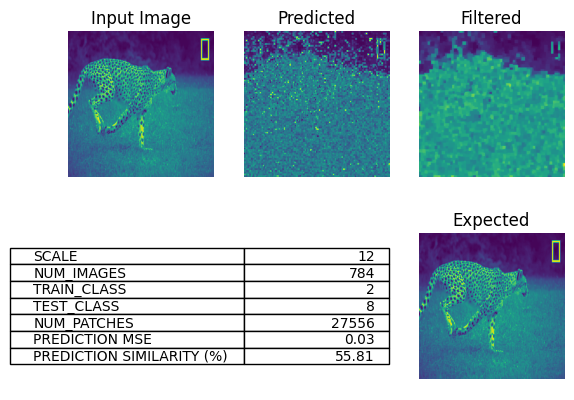

In [21]:
#DISPLAY RESULTS

input_image_local = tf.squeeze(input_image)
# print('input_image_local shape', input_image_local.shape)

input_image_local = cv2.imread("cheetah.png", cv2.IMREAD_GRAYSCALE)

input_image_local = frame1

#expected_img = ndimage.rotate(original_img, ROTATION, reshape=False, cval=0)
expected_img = ndimage.affine_transform(input_image_local,
                                        transform,
                                        output_shape=(SCALE * 28, SCALE * 28),
                                        cval=0.0)

expected_img = frame2


predicted_img = apply_mapping(input_image_local, mapping, params)

# Display result of transformation
result_fig = plt.figure()

result_fig.add_subplot(2, 3, 1)
input_image_local = tf.squeeze(input_image_local)
plt.imshow(input_image_local)
plt.axis('off')
plt.title('Input Image')

# Mask for debugging which ppixels are moving where
# mask = np.ones_like(input_image_local)
# STRIP_W = 5
# offset = -20
# mask[:, W // 2 - STRIP_W + offset: W // 2 + STRIP_W + offset] = 1

# result_fig.add_subplot(1, 4, 2)
# plt.imshow(mask)
# plt.axis('off')
# plt.title('Mask')

# result_fig.add_subplot(1, 4, 3)
# plt.imshow(mask * input_image_local)
# plt.axis('off')
# plt.title('Mask & Input')

result_fig.add_subplot(2, 3, 2)
predicted_img = tf.squeeze(predicted_img)
plt.imshow(predicted_img)
plt.axis('off')
plt.title('Predicted')

# Filter images

filter_img = ndimage.grey_opening(predicted_img, size=(5, 5))
filter_img = ndimage.grey_closing(filter_img, size=(5, 5))

result_fig.add_subplot(2, 3, 3)
plt.imshow(filter_img)
plt.axis('off')
plt.title('Filtered')

mse_val, ssim_val = compare_images(predicted_img, expected_img)

plot_data = {
    'SCALE': [SCALE],
    'NUM_IMAGES': [NUM_IMAGES],
    'TRAIN_CLASS': [TRAIN_CLASS],
    'TEST_CLASS': [FINAL_TEST_CLASS],
    'NUM_PATCHES': [NUM_PATCHES],
    'PREDICTION MSE': [f"{mse_val:.2f}"],
    'PREDICTION SIMILARITY (%)': [f"{ssim_val:.2f}"]
}

table_data = [plot_data[key] for key in plot_data]
table_columns = list(plot_data.keys())

ax_table = result_fig.add_subplot(2, 3, 5)
table = ax_table.table(cellText=table_data, rowLabels=table_columns, loc='center')
ax_table.axis('off')

result_fig.add_subplot(2, 3, 6)
expected_img = tf.squeeze(expected_img)

plt.imshow(expected_img)
plt.axis('off')
plt.title('Expected')
plt.show()